In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.metrics import accuracy_score , confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import theano.tensor as tt
import seaborn as sns
#import jax.numpy as jnp

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pd.read_csv("clean_sample_norm.csv")

In [ ]:
print(data.info())

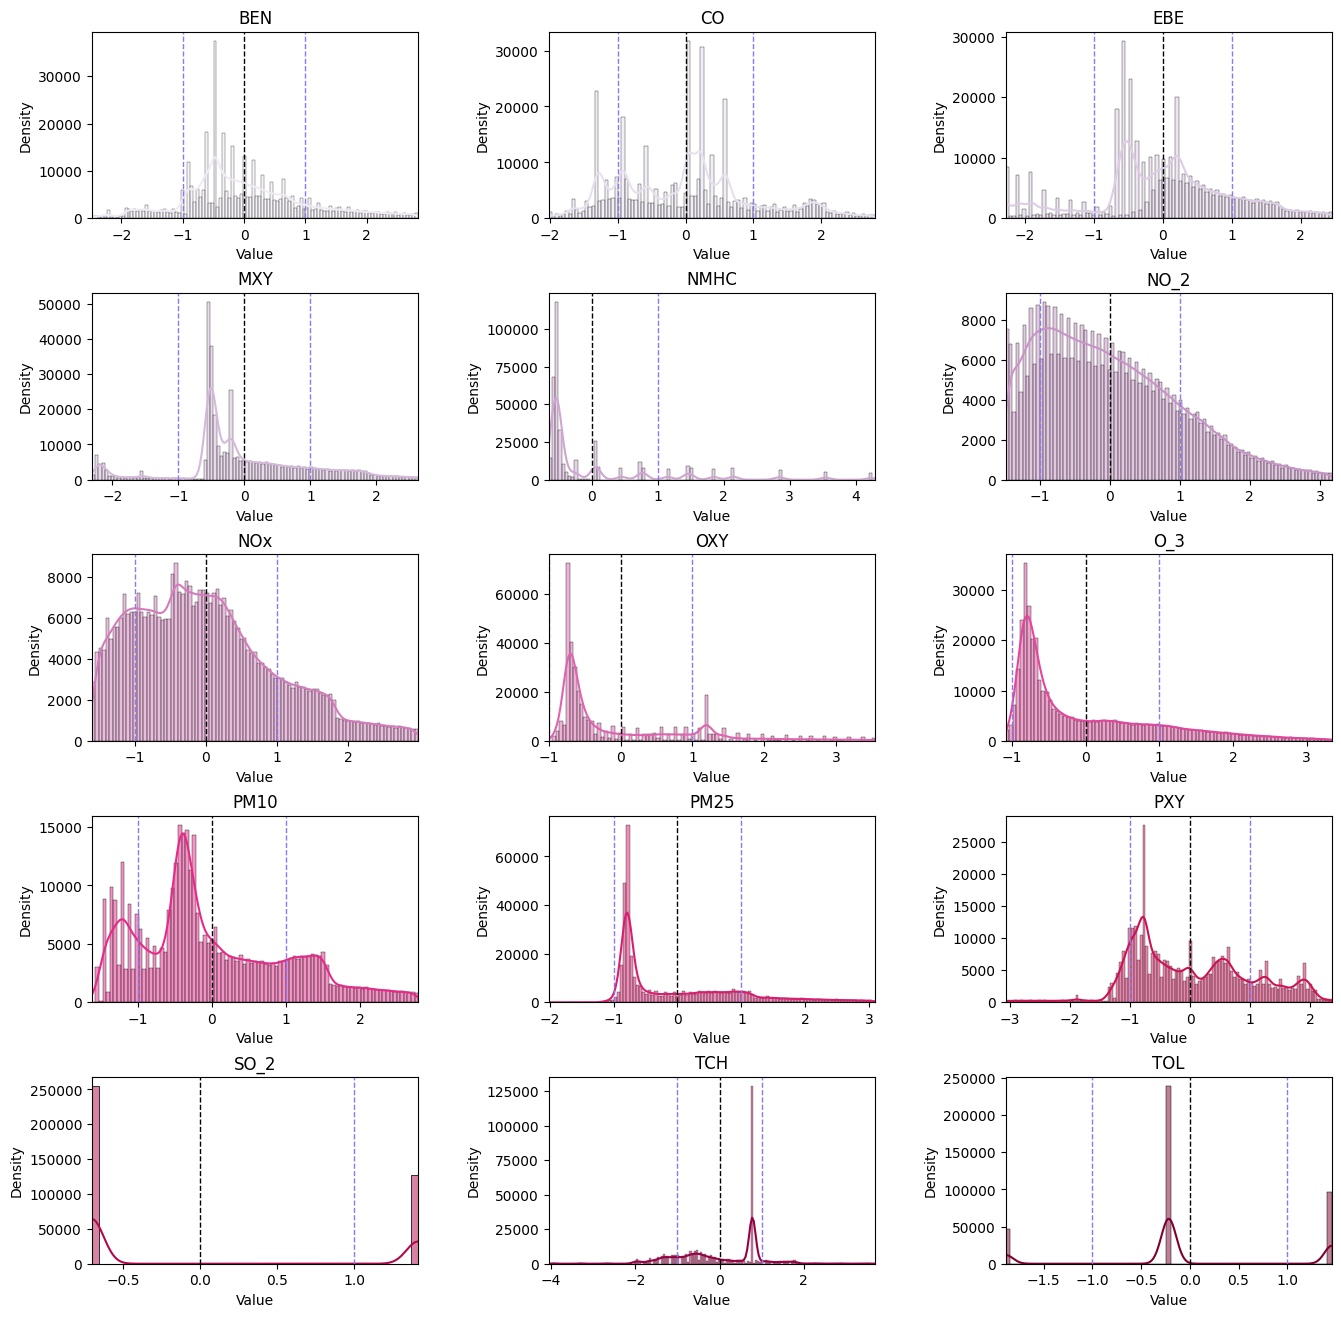

In [35]:
# Get the columns to plot
pollutants = data.columns[0:15] 

# Create a figure with 5x3 subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

# Plot a histogram for each column
for i, pollutant in enumerate(pollutants):
    
    # Get the data for the column
    dat = data[pollutant].dropna()
    
    # Determine the subplot location based on the column index
    row = i // 3
    col = i % 3
    
    # get the range of values in the column, ignoring NaN and Inf
    x_min = np.nanmin(data[pollutant][np.isfinite(data[pollutant])])
    x_max = np.nanmax(data[pollutant][np.isfinite(data[pollutant])])
    
    # calculate number of bins using IQR rule
    n = len(data[pollutant])
    std = np.std(data[pollutant])
    k = 3.5 * std / (n**(1/3))
    num_bins = int((x_max - x_min) / k) if k != 0 else 1 # Added this line to handle the case when k=0
    
    # Plot the histogram with kde
    sns.histplot(data[pollutant], kde=True, bins=num_bins, color=sns.color_palette("PuRd", 15)[i], ax=axs[row, col])
    
    # Add a vertical line for the mean
    mean = data[pollutant].mean()
    axs[row, col].axvline(mean, color='k', linestyle='dashed', linewidth=1)
    
    # Add a vertical line for the standard deviation
    std = data[pollutant].std()
    axs[row, col].axvline(mean+std, color='#8C78F0', linestyle='dashed', linewidth=1)
    axs[row, col].axvline(mean-std, color='#8C78F0', linestyle='dashed', linewidth=1)
    
    # Set the title and axis labels
    axs[row, col].set_title(pollutant)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_xlim([dat.min(), dat.max()])  # set x-axis range

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

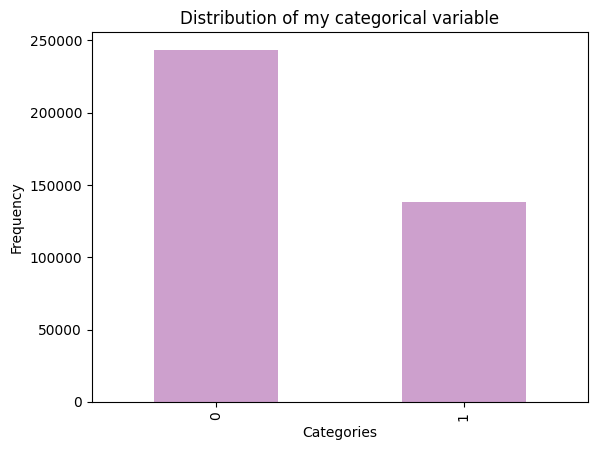

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the color palette to PuRd
sns.set_palette('PuRd',2)

# Create bar chart of the categorical variable
data['AQI_GenPop_Index'].value_counts().plot(kind='bar')

# Create bar chart of the categorical variable
#data['AQI_Index'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Distribution of my categorical variable')
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Display plot
plt.show()

In [3]:
feature_columns = ['BEN','EBE', 'CO', 'NMHC', 'NO_2', 'O_3', 'PM10', 'PM25', 'SO_2','TCH','TOL'] #11 features
#feature_columns = ["NO_2", "O_3", "PM10", "PM25", "SO_2"]
#feature_columns = ['BEN','EBE', 'CO', 'NMHC', 'NO_2','NOx', 'O_3', 'PM10', 'PM25', 'SO_2','TCH', 'TOL','MXY','OXY','PXY'] #15features
X = data[feature_columns].values

In [4]:
# Prepare the target variable y
target_column = "AQI_GenPop_Index"  # or "AQI_GenPop_Index"
y = data[target_column].values

In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_features = X_train.shape[1]
#n_classes = len(np.unique(y_train)) #for Multi Class LogReg
n_classes=2

In [81]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (305530, 11)
Shape of y_train: (305530,)


In [ ]:
#Vuew data mean and std
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

print(f"Mean of features: {mean}")
print(f"Std of features: {std}")

In [6]:
# GEN_POP - Build the Binary Bayesian logistic regression model in PyMC3
with pm.Model() as AQI_model:
    # Priors for coefficients and bias, with better starting values
    coeffs = pm.Normal("coeffs", mu=0, sigma=1, shape=n_features, testval=np.zeros((n_features)))
    bias = pm.Normal("bias", mu=0, sigma=1)
    
# Define the logistic function with added epsilon
def logistic(x, epsilon=1e-6):
    return 1 / (1 + tt.exp(-x)) + epsilon

    p = pm.math.sigmoid(pm.math.dot(X_train, coeffs) + bias)

    # Define the Bernoulli likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (4 chains in 8 jobs)
CompoundStep
>Metropolis: [bias]
>Metropolis: [coeffs]
CompoundStep
>Metropolis: [bias]
>Metropolis: [coeffs]


Sampling 4 chains for 1_500 tune and 15_000 draw iterations (6_000 + 60_000 draws total) took 92 seconds.
The number of effective samples is smaller than 10% for some parameters.


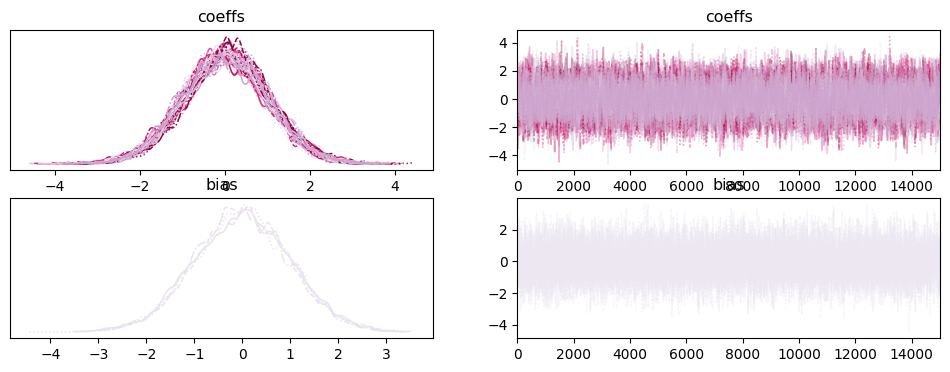

In [7]:
# MCMC
with AQI_model:
    step= pm.Metropolis()
    #step=pm.NUTS(target_accept=0.8)
    #step=pm.HamiltonianMC()
    trace = pm.sample(15000, tune=1500, chains=4, cores=8, step=step, progressbar=True)
    sns.set_palette("PuRd",8)
    pm.plot_trace(trace)

In [ ]:
with AQI_model:
    print(pm.summary(trace))

In [94]:
# BINARY Predicting on test data
def predict_proba(X, trace):
    linear = np.dot(X, trace["coeffs"].mean(axis=0)) + trace["bias"].mean()
    proba = 1 / (1 + np.exp(-linear))
    return np.column_stack((1 - proba, proba))

y_test_pred_proba = predict_proba(X_test, trace)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [95]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:")
print(cm)

# Evaluation of model performance
accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy:", accuracy)

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro') #try also 'micro' or 'weighted'
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

Confusion matrix:
[[11758 37016]
 [25749  1860]]
Test accuracy: 0.1782857442100991
Precision: 0.18066628865900788
Recall: 0.15422019926868247
F1 score: 0.16425189268589221


In [ ]:
#AYTA POU EIXA MIN TA PEIRAKSEIS

In [10]:
# Build the Bayesian logistic regression model in PyMC3
with pm.Model() as AQI_model:
    # Priors for coefficients and bias, with better starting values
    coeffs = pm.Normal("coeffs", mu=0, sigma=1, shape=(n_features, n_classes - 1), testval=np.zeros((n_features, n_classes - 1)))
    bias = pm.Normal("bias", mu=0, sigma=1, shape=(n_classes - 1,), testval=np.zeros(n_classes - 1))

    # Define the softmax function using Theano functions with added epsilon for numerical stability
    def softmax(x, epsilon=1e-6):
        e_x = tt.exp(x - tt.max(x, axis=1, keepdims=True))
        e_x += epsilon
        return e_x / tt.sum(e_x, axis=1, keepdims=True)

        # Likelihood function (using the custom softmax function for multi-class classification)
        linear = pm.math.dot(X_train, coeffs) + bias
        softmax_probs = softmax(linear)

        # Define the categorical likelihood
        y_obs = pm.Categorical("y_obs", p=softmax_probs, observed=y_train)

c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (15 chains in 8 jobs)
NUTS: [bias, coeffs]


Sampling 15 chains for 2_000 tune and 20_000 draw iterations (30_000 + 300_000 draws total) took 702 seconds.


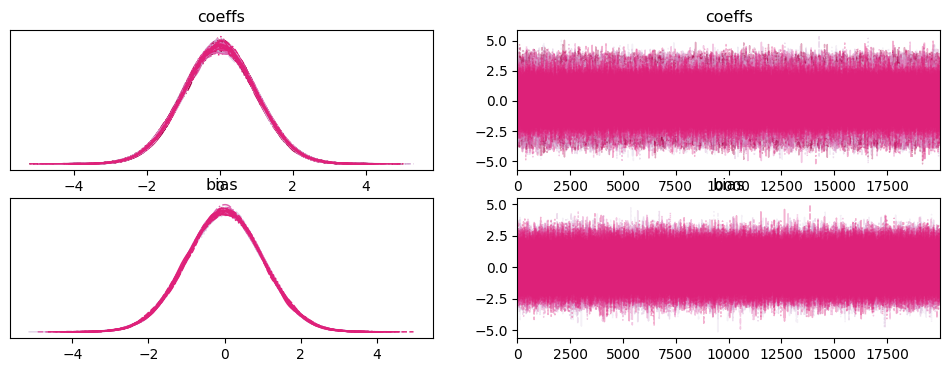

In [24]:
# MCMC
with AQI_model:
    #step= pm.Metropolis()
    step=pm.NUTS(target_accept=0.8)
    trace = pm.sample(20000, tune=2000, chains=15, cores=8, step=step, progressbar=True)
    pm.plot_trace(trace)

In [12]:
with AQI_model:
    pm.summary(trace)

In [28]:
#MULTI-CLASS:Predicting on test data
def predict_proba(X, trace):
  linear = np.dot(X, trace["coeffs"].mean(axis=0)) + trace["bias"].mean(axis=0)
  softmax = np.exp(linear - np.max(linear, axis=1, keepdims=True))
  return softmax / np.sum(softmax, axis=1, keepdims=True)

y_test_pred_proba = predict_proba(X_test, trace)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:")
print(cm)

Confusion matrix:
[[    0     0     0     0     0     0]
 [   93  1633  3181  1825     0     0]
 [  840 11079 12522  8758     0     0]
 [  484  2008  2306  3737     0     0]
 [  194   370   559  1180     0     0]
 [ 7941    10  1681 15691     0     0]]


In [26]:
# Evaluation of model performance
accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.06953424801556012


In [27]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_test_pred, average='macro') #try also 'micro' or 'weighted'
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)

Precision: 0.0446996105010467
Recall: 0.0412768396512762
F1 score: 0.041882190013386444


c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.metrics import precision_score, recall_score

precision_micro = precision_score(y_test, y_test_pred, average='micro')
recall_micro = recall_score(y_test, y_test_pred, average='micro')

print("Micro-averaged precision:", precision_micro)
print("Micro-averaged recall:", recall_micro)


Micro-averaged precision: 0.15955685223150923
Micro-averaged recall: 0.15955685223150923


In [18]:
from sklearn.metrics import precision_score, recall_score

precision_macro = precision_score(y_test, y_test_pred, average='macro')
recall_macro = recall_score(y_test, y_test_pred, average='macro')

print("Macro-averaged precision:", precision_macro)
print("Macro-averaged recall:", recall_macro)


Macro-averaged precision: 0.1230429343060075
Macro-averaged recall: 0.11063284582724964


c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\eleni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
